# Geometry Data Mining
By Hangxin Lu 30.01.2017

### Introduction
Using Geometrical data in geojson data structures, describing for every designs their surfaces and corrdinates of the vertexs. We want extracts geometrical features of the design scenarios to distinguish different designs. We defines the **geometrical(topogical) features** of the topologies  as:

* Number of neighbourhood within each design
* Surface Areas of (adjacent) empty spaces 
* Surface Areas of building blocks
* Volumn of building blocks 
* Height distribution
* Orientation of building blocks(with regards to borders)

### Methods

* Computational Geometry
* Geometry Feature Learning [Link](https://en.wikipedia.org/wiki/Geometric_feature_learning)
* Object recognition/image segmentation [Link](https://github.com/geometalab/OSMDeepOD) 

### Library

* Shapely, Fiona, and Descarte
* Pysal ([Python Spatial Analysis Library](http://pysal.readthedocs.io/en/v1.11.0/library/index.html#python-spatial-analysis-library))

## Setup

In [180]:
# Basic Stuff
import numpy as np
import json
from prettytable import PrettyTable
import itertools
import pandas as pd
# Geo Stuff
import shapely
from shapely.geometry import Polygon

# Plot Stuff
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline 

# Machine Learning Stuff
from sklearn import cluster,metrics
from scipy.spatial import distance
from sklearn.model_selection import GridSearchCV

# turn warnings off
import warnings
warnings.filterwarnings('ignore')

#debug stuff
import pdb
from IPython.core.debugger import Tracer

## Load Data

Load design scenario and each design contains 47 buildings. Project to 2D and extract centroid of the polygon. 

In [151]:
with open('../data/geometry/1.json') as f:
    data = json.load(f)

In [152]:
# Project shapes onto 2D polygons and Extract centroid  
# polygon_alles contains 2Dploygon and X contain centroid in 3D in shape of (47,3)
centroid_alles = []
polygon_alles = []
points_alles = []
for i,feature in enumerate(data['features']):
    if (i > 0):
#for each cube, find the collections of all 8 points
        convexs = set()
        centroid = []

        for surfaces in feature['geometry']['coordinates']:
            
            surface = surfaces[0]
            surface_z = set(x[2] for x in surface)
            if len(surface_z) == 1:
                surface_2d = list((x[0],x[1]) for x in surface)
            for p in surface:
                convexs.add(tuple(p))
        convexs = list(convexs)
        centroid = [sum([x[0] for x in convexs])/8.0,sum([x[1] for x in convexs])/8.0,sum([x[2] for x in convexs])/8.0]
        centroid_alles.append(centroid)
        points_alles.append(list(itertools.chain.from_iterable(surface_2d[0:4])))
        polygon = Polygon(surface_2d)
        polygon = shapely.geometry.polygon.orient(polygon)
        polygon_alles.append(polygon)
X = np.matrix(centroid_alles)
X_points = np.matrix(points_alles)
print(X.shape)

(47, 3)


In [154]:
#list(itertools.chain.from_iterable(surface_2d[0:4]))
print(X_points.shape)

(47, 8)


## Compute pairwise distance

compute Pairwise distance of polygons/centroids 

In [25]:
#we want to test what is distance between polygons in shapely
poly_1 = Polygon([(1,1),(0,1),(0,0),(1,0)])
poly_2 = Polygon([(3,1),(2,1),(2,0),(3,0)])
poly_3 = Polygon([(2,1),(1,0),(2,-1),(3,0)]) 
poly_4 = Polygon([(3,1),(2,0),(3,-1),(4,0)]) 
poly_5 = Polygon([(1,1),(0,1),(1,0),(0,0)])
poly_6 = Polygon([(3,1),(2,1),(2,0),(3,0)])
test_distance = poly_5.distance(poly_6)
print(test_distance)
#results shows polygon distance is the min distances between sets of vertexes 

1.0


In [26]:
#Compute pairwise distance between polygons
adj_poly = np.zeros((47,47))
for c,c_poly in enumerate(polygon_alles):
    for a,a_poly in enumerate(polygon_alles):
        adj_poly[c,a] = c_poly.distance(a_poly)
print(adj_poly)

[[     0.           5751.88359607  26461.99134218 ...,  34522.51384018
   13862.88756126  17958.04066531]
 [  5751.88359607      0.          21534.42877437 ...,  23396.17232335
   19239.29259342  21582.99369975]
 [ 26461.99134218  21534.42877437      0.         ...,  31231.97165908
   14867.5741459   11520.37450165]
 ..., 
 [ 34522.51384018  23396.17232335  31231.97165908 ...,      0.
   43797.06509316  44281.96182878]
 [ 13862.88756126  19239.29259342  14867.5741459  ...,  43797.06509316
       0.           1202.48975152]
 [ 17958.04066531  21582.99369975  11520.37450165 ...,  44281.96182878
    1202.48975152      0.        ]]


In [156]:
# compute pairwise distance between centroids
Y = distance.pdist(X,'euclidean')# pairwise distance 平直的
Z = distance.cdist(X,X,'euclidean')# 47 by 47 

Y_points = distance.pdist(X_points,'euclidean')
Z_points = distance.cdist(X_points,X_points,'euclidean')
#2D matrix
X_2D = X[:,0:2]
Y_2D = distance.pdist(X_2D,'euclidean')# pairwise distance 平直的
Z_2D = distance.cdist(X_2D,X_2D,'euclidean')# 47 by 47  

Let's take a look at the ditribution of the distance pairwise comparision by histrogram 

(array([ 10.,  16.,  19.,  16.,  16.,  20.,  32.,  37.,  40.,  25.,  23.,
         36.,  35.,  32.,  32.,  42.,  37.,  33.,  39.,  33.,  43.,  32.,
         28.,  41.,  18.,  29.,  22.,  27.,  31.,  25.,  27.,  20.,  21.,
         19.,  14.,  14.,  18.,  14.,  14.,   9.,   9.,  10.,   5.,   2.,
          4.,   5.,   1.,   4.,   0.,   2.]),
 array([  3977.09931448,   5510.28527435,   7043.47123422,   8576.65719409,
         10109.84315396,  11643.02911383,  13176.2150737 ,  14709.40103357,
         16242.58699344,  17775.77295331,  19308.95891318,  20842.14487305,
         22375.33083292,  23908.51679279,  25441.70275266,  26974.88871253,
         28508.0746724 ,  30041.26063227,  31574.44659214,  33107.63255201,
         34640.81851188,  36174.00447176,  37707.19043163,  39240.3763915 ,
         40773.56235137,  42306.74831124,  43839.93427111,  45373.12023098,
         46906.30619085,  48439.49215072,  49972.67811059,  51505.86407046,
         53039.05003033,  54572.2359902 ,  56105.4

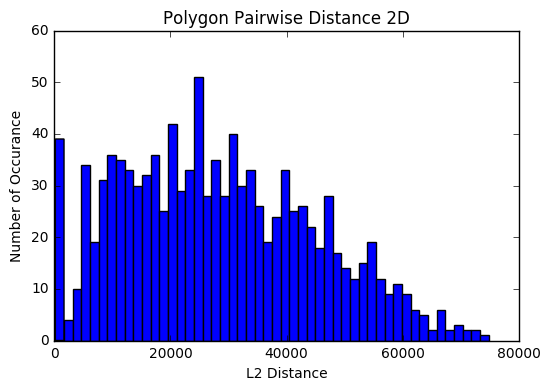

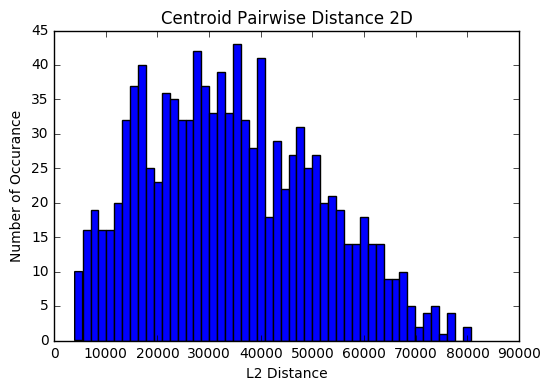

In [28]:
#flatten the pairwise distance
pw_dis = list(adj_poly[np.triu_indices(47)])
pw = [y for y in pw_dis if y != 0.0]

fig = plt.figure()
a=fig.add_subplot(1,1,1)
a.set_title("Polygon Pairwise Distance 2D")
plt.xlabel("L2 Distance")
plt.ylabel("Number of Occurance")
plt.hist(pw,bins=50)
plt.locator_params(axis = 'x', nbins = 4)

fig = plt.figure()
b=fig.add_subplot(1,1,1)
b.set_title("Centroid Pairwise Distance 2D")
plt.xlabel("L2 Distance")
plt.ylabel("Number of Occurance")
plt.hist(Y_2D,bins=50)

## Plot the geometry

First, let's take a look at the design scenario. ![Toplogy Sample](https://qua-kit.ethz.ch/mooc/proposals/preview/302)

We display the polygon and centroid with 2D projection. 

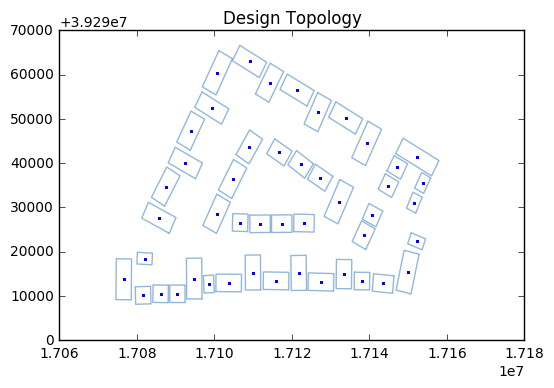

In [59]:
from descartes import PolygonPatch
fig = plt.figure()
ax = fig.add_subplot(111)
for i,poly in enumerate(polygon_alles):
    x,y = poly.exterior.xy
    ax.plot(x, y, color='#6699cc', alpha=0.7,
    linewidth=1, solid_capstyle='round', zorder=2)
    ax.scatter(X[:,0],X[:,1],c='b',s=1,edgecolors='face')


ax.set_title('Design Topology')

## Building Neighbourhood Detection

We applied Density-based spatial clustering of applications with noise (DBSCAN) to detect neighbourhood of buildings. Identify class in the spatial space.

In [85]:
eps = list(np.arange(1,10,0.1))
param_grid = {'eps':eps,'min_sample':[2,3,4]}
adj_poly.shape
print(adj_poly)

[[     0.           5751.88359607  26461.99134218 ...,  34522.51384018
   13862.88756126  17958.04066531]
 [  5751.88359607      0.          21534.42877437 ...,  23396.17232335
   19239.29259342  21582.99369975]
 [ 26461.99134218  21534.42877437      0.         ...,  31231.97165908
   14867.5741459   11520.37450165]
 ..., 
 [ 34522.51384018  23396.17232335  31231.97165908 ...,      0.
   43797.06509316  44281.96182878]
 [ 13862.88756126  19239.29259342  14867.5741459  ...,  43797.06509316
       0.           1202.48975152]
 [ 17958.04066531  21582.99369975  11520.37450165 ...,  44281.96182878
    1202.48975152      0.        ]]


In [134]:
# DBSCAN
# define the max distance within each cluster
# define the min samples within each cluster

# Plot pairwise distance v.s. percentile 


# DBSCAN parameter Grid serach(Doenst'workt! Seems Sklearn doesnt support grid
# search for unsupervised learning)
## define score metrics
def silhouette_score(estimator, data):
    clusters = estimator.fit_predict(data)
    print ("labels",clusters)
    score = metrics.silhouette_score(data,clusters,metric="precomputed")
    print ("si",score)
    return score
max_distance = np.percentile(pw,4)
dbscan = cluster.DBSCAN(metric="precomputed")
param_dist = {'eps':[max_distance],'min_samples':[3]}

## run grid search
clf = GridSearchCV(
    dbscan,
    param_grid = param_dist,
    scoring=silhouette_score,
    cv = 1
)
#clf.fit(data)
#search_result = clf.cv_results_
#print(search_result)

In [140]:
print(covexs)

NameError: name 'covexs' is not defined

In [182]:
# DBSCAN parameter search(Self defined)
##
min_per = 3
max_per = 5
percentile = list(np.arange(min_per,max_per,0.1))
eps_ = []

t = PrettyTable(['percentile','eps','min_sample','silhouette'])

# for val in percentile:
#     eps_.append(np.percentile(pw,val))
min_samples_ = [2,3]
df = pd.DataFrame([0,0,0,0],columns = ['percentile','eps','min_sample','silhouette'])
for min_samples in min_samples_:
    for val in percentile:
        eps = np.percentile(pw,val)
        dbscan = cluster.DBSCAN(
            eps=eps,
            min_samples=min_samples,
            metric='precomputed')
        labels = dbscan.fit_predict(adj_poly)
        SI_score = metrics.silhouette_score(adj_poly,labels,metric="precomputed")
        
        t.add_row([val,eps,min_samples,SI_score])
        print(t)
        
        df_val = pd.DataFrame(np.array([[val,eps,min_samples,SI_score]]),columns = ['percentile','eps','min_sample','silhouette'])
        df.append(df_val, ignore_index=True)

ValueError: Shape of passed values is (1, 4), indices imply (4, 4)

[ 0  2  1 -1  1  0  1  2  2  1  0  1  1  1  2  3  2  2  2  1  2  3 -1  3  3
  1  2  1  1  3  3  3  1  2  3  3  3  0  2  1  1  2  0  1  3  1  1]


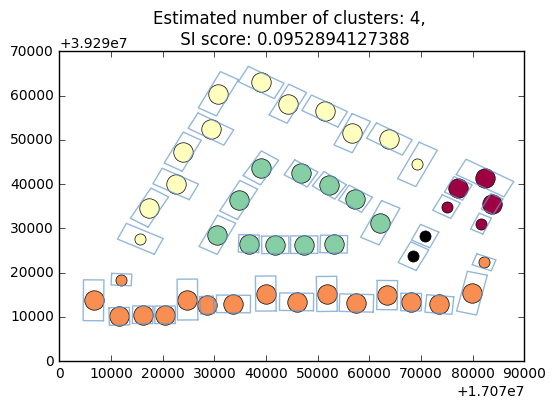

In [183]:

max_distance = np.percentile(pw,4)
dbscan = cluster.DBSCAN(eps=max_distance,min_samples=3,metric='precomputed')
#dbscan = cluster.DBSCAN(eps=max_distance,min_samples=3)


labels = dbscan.fit_predict(adj_poly)
#labels = dbscan.fit_predict(X_points)
print(labels)
SI_score = metrics.silhouette_score(adj_poly,labels,metric="precomputed")
#SI_score = metrics.silhouette_score(X_points,labels)



core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X_2D[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

    xy = X_2D[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=8)

for i,poly in enumerate(polygon_alles):
    x,y = poly.exterior.xy
    plt.plot(x, y, color='#6699cc', alpha=0.7,
    linewidth=1, solid_capstyle='round', zorder=2)
    
plt.title('Estimated number of clusters: %d, \n SI score: %s' % (n_clusters_,SI_score))
plt.show()
